In [1]:
import os
from copy import copy
import time
import ast
import argparse
from glob import glob

import pandas as pd
import numpy as np
import geopandas as gpd 

import matplotlib as mpl
import matplotlib.pyplot as plt

# https://planetarycomputer.microsoft.com/dataset/naip#Example-Notebook
# https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/

In [2]:
def list_of_list_of_inundation_categories(temp_key = "&"):
    # identify column name corresponding to inundation data
    temp_key = "&"
    slosh_cols_by_category_general = ["Category"+temp_key+"_data_present","Category"+temp_key+"_values","Category"+temp_key+"_leveed_areas"]
    slosh_cols_by_category = [[s.replace("&",str(i)) for s in slosh_cols_by_category_general] for i in range(1,6)]
    return(slosh_cols_by_category)


def combine_inundation_data_for_analysis(inundation_values_for_analysis_dict):
    #compile data for by category
    inundation_values_for_analysis_df = pd.DataFrame()
    for category_name in inundation_values_for_analysis_dict.keys(): 
        inundation_values_for_analysis_df = pd.concat([inundation_values_for_analysis_df, 
                                                       inundation_values_for_analysis_dict[category_name]["geodataframe"]], axis=0)
    inundation_values_for_analysis_gdf = gpd.GeoDataFrame(inundation_values_for_analysis_df)
    return inundation_values_for_analysis_gdf


def subset_tanks_with_data_by_category(tile_level_annotations_slosh_gdf, general_variables, slosh_cols_by_category):
    #subset by category tanks that have inundation data 
    inundation_values_for_analysis = {}
    for slosh_cols in slosh_cols_by_category:
        print(slosh_cols)
        if any(tile_level_annotations_slosh_gdf.columns.isin(slosh_cols)):
            tile_level_annotations_slosh_gdf_cat_subset = copy(tile_level_annotations_slosh_gdf[general_variables+slosh_cols])
            tile_level_annotations_slosh_gdf_cat_subset = copy(tile_level_annotations_slosh_gdf_cat_subset[\
                                                          tile_level_annotations_slosh_gdf_cat_subset[slosh_cols[0]] == True])
            length = len(tile_level_annotations_slosh_gdf_cat_subset) 
            category_name = slosh_cols[0].split("_")[0]
            tile_level_annotations_slosh_gdf_cat_subset['category'] = length * [category_name]
            #clean for combination
            tile_level_annotations_slosh_gdf_cat_subset.drop(slosh_cols[0], inplace=True, axis=1)
            tile_level_annotations_slosh_gdf_cat_subset = tile_level_annotations_slosh_gdf_cat_subset.rename(columns={
                                                          slosh_cols[1]: "inundation", 
                                                          slosh_cols[2]: "leveed_areas"})
            #write to dictionary
            
            inundation_values_for_analysis[category_name] = {"category_name":category_name, "length": length,
                                       "geodataframe":tile_level_annotations_slosh_gdf_cat_subset}
    return inundation_values_for_analysis

def capacity_estimation(gdf):
    # subset based on reasonable heights
    gdf.loc[gdf['height'] <=1, 'height'] = np.nan
    gdf.loc[gdf['height'] >30, 'height'] = np.nan

    gdf["capacity"] = np.nan 

    can_estimate_capacity = (~gdf['height'].isnull()) & (gdf['object_class'] != "spherical")

    has_height_gdf = copy(gdf[can_estimate_capacity])
    has_height_gdf["capacity"] = np.pi * (has_height_gdf["diameter"] / 2) ** 2 * has_height_gdf["height"]
    gdf.loc[can_estimate_capacity, 'capacity'] = has_height_gdf['capacity']
    return gdf

In [4]:

def get_args_parse():
    parser = argparse.ArgumentParser(
        description='Add slosh data to tile level annotation')
    parser.add_argument('--tile_level_annotations_slosh_gdf_filename', type=str, 
                        help='filename for tile level annotationd with slosh data added (including extension).')
    parser.add_argument('--output_dir', type=str, default="/hpc/group/borsuklab/nat_hazard_data/slosh/risk", 
                        help='path to directory to store analysis outputs.')
    parser.add_argument('--tile_level_annotations_fragility_analysis_output_filename', type=str, 
                        help='file name for tile level annotations containing processed data for fragility analysis.')
    parser.add_argument('--temp_key', type=str, default= "&", 
                        help="key to iterate over to get slosh cols")    
    args = parser.parse_args() 
    return args

In [5]:
import sys
sys.argv = ['my_notebook']
args = get_args_parse()
args.detect_tank_dir="/hpc/group/borsuklab/csr33/object_detection/height_estimation"

More targeted assessments at known industrial sites
where height estimation is less than 1, we ignore the height,

# read in complete prediction dataset

In [6]:
compiled_predicted_tank = gpd.read_file("/hpc/group/borsuklab/csr33/object_detection/compiled_predicted_tank.geojson")
compiled_predicted_tank = capacity_estimation(compiled_predicted_tank)

## estimate capacity over all predictions 

In [8]:
num_objects_h = compiled_predicted_tank[compiled_predicted_tank.height.notnull()]
np.sum(num_objects_h.object_class.isin(["external_floating_roof_tank", "closed_roof_tank"]))

99709

In [9]:
compiled_predicted_tank_with_capacity = compiled_predicted_tank[compiled_predicted_tank.capacity.notnull()]
estimated_capacity = np.sum(compiled_predicted_tank_with_capacity.capacity)
print(estimated_capacity/1000)
#interpolate capacity
print(((estimated_capacity / len(compiled_predicted_tank_with_capacity)) *len(compiled_predicted_tank) ) /1000)

318611.5296318972
609920.8203065367


In [ ]:
#slosh = gpd.read_file("/hpc/group/borsuklab/csr33/object_detection/detected_tanks_slosh_data_added.geojson")

# Estimate capacity by region

In [10]:
# Read in state data
state_boundary_path = "/hpc/group/borsuklab/political-boundaries/states/generalized-conus-states.shp"
state_boundary = gpd.read_file(state_boundary_path)
crs = "EPSG:4326"
state_boundary = state_boundary.to_crs(crs)

In [11]:
west_central_gulf = state_boundary[state_boundary.STATE_NAME.isin(["Texas", "Louisiana","Alabama","Mississippi"])]
west_central_gulf_predicted = gpd.sjoin(compiled_predicted_tank, west_central_gulf)
#estimate capacity
west_central_gulf_predicted_tank_with_capacity = capacity_estimation(west_central_gulf_predicted)

#estimate total
west_central_gulf_predicted_tank_with_capacity = west_central_gulf_predicted[west_central_gulf_predicted.capacity.notnull()]
estimated_west_central_gulf_capacity = np.sum(west_central_gulf_predicted_tank_with_capacity.capacity)

print(estimated_west_central_gulf_capacity/1000)
#interpolate capacity
print(((estimated_west_central_gulf_capacity / len(west_central_gulf_predicted_tank_with_capacity)) *len(west_central_gulf_predicted) ) /1000)

211548.28173808404
331332.0317819497


In [12]:
for i, tank in gpd.sjoin(compiled_predicted_tank, state_boundary).groupby("STATE_NAME"):
    print(i)
    print(len(tank), len(tank)/len(compiled_predicted_tank))

Alabama
6821 0.0353762453776457
California
14693 0.07620336803016393
Connecticut
2816 0.014604824363502461
Delaware
2573 0.013344535897475793
District of Columbia
143 0.0007416512372091093
Florida
13069 0.06778069943416679
Georgia
2318 0.012022010963991017
Louisiana
42526 0.22055566792695513
Maine
2203 0.011425578150850824
Maryland
7273 0.037720485651901066
Massachusetts
3156 0.01636819094148216
Mississippi
4637 0.02404920830027021
New Hampshire
516 0.0026761681006986044
New Jersey
8496 0.04406341896033981
New York
7258 0.03764269006757843
North Carolina
11467 0.05947213102850949
Pennsylvania
3200 0.016596391322161886
Rhode Island
889 0.0046106849641880995
South Carolina
4214 0.021855372822371936
Texas
39695 0.20587304797913003
Vermont
21 0.00010891381805168739
Virginia
8013 0.041558401145151004


# reshape slosh data so that inundation data is one column

# read in data slosh data

In [14]:
detected_tanks_slosh_data_added = gpd.read_file("/hpc/group/borsuklab/csr33/object_detection/detected_tanks_slosh_data_added.geojson")
slosh_cols_by_category = list_of_list_of_inundation_categories(args.temp_key)
detected_tanks_slosh_data_added_dict = subset_tanks_with_data_by_category(detected_tanks_slosh_data_added, 
                                                                         ["id",'height', 'diameter', "object_class",
                                                                          "confidence", "geometry"],
                                                                         slosh_cols_by_category)
detected_tanks_slosh_data_added_gdf = combine_inundation_data_for_analysis(detected_tanks_slosh_data_added_dict)
detected_tanks_slosh_data_added_gdf = capacity_estimation(detected_tanks_slosh_data_added_gdf)

['Category1_data_present', 'Category1_values', 'Category1_leveed_areas']
['Category2_data_present', 'Category2_values', 'Category2_leveed_areas']
['Category3_data_present', 'Category3_values', 'Category3_leveed_areas']
['Category4_data_present', 'Category4_values', 'Category4_leveed_areas']
['Category5_data_present', 'Category5_values', 'Category5_leveed_areas']


In [15]:
detected_tanks_slosh_data_added_gdf = detected_tanks_slosh_data_added_gdf.to_crs("EPSG:2163")
detected_tanks_slosh_data_added_gdf["centroid"] = detected_tanks_slosh_data_added_gdf.centroid#cx[-88.499003:-76.134554, 30.382405:37.051745]#.plot(

compiled_predicted_tank = compiled_predicted_tank.to_crs("EPSG:2163")
compiled_predicted_tank["centroid"] = compiled_predicted_tank.centroid

state_boundary = state_boundary.to_crs("EPSG:2163")

In [16]:

tank_gdfs = []
for cat, tank_gdf, in detected_tanks_slosh_data_added_gdf.groupby(by="category"):
    # num of tanks exposed
    print(cat, "num tanks exposed", len(np.unique(tank_gdf.index)))
    #print number of tanks exposed
    tank_with_capacity = tank_gdf[tank_gdf.capacity.notnull()]
    print(cat, "num tanks with capacity information", len(tank_with_capacity))
    capacity = np.sum(tank_with_capacity.capacity)
    print( "calaculated capacity 1000m3", capacity / 1000)

    print("infered capacity 1000m3",((capacity / len(tank_with_capacity)) *len(tank_gdf) ) / 1000)

    tank_gdfs.append(tank_with_capacity)

Category1 num tanks exposed 11429
Category1 num tanks with capacity information 5279
calaculated capacity 1000m3 28651.0430126928
infered capacity 1000m3 62029.31816481645
Category2 num tanks exposed 20248
Category2 num tanks with capacity information 10538
calaculated capacity 1000m3 55915.00771922176
infered capacity 1000m3 107436.61760284705
Category3 num tanks exposed 30729
Category3 num tanks with capacity information 17875
calaculated capacity 1000m3 96325.99870605099
infered capacity 1000m3 165594.49590144007
Category4 num tanks exposed 43784
Category4 num tanks with capacity information 27302
calaculated capacity 1000m3 160431.52486264403
infered capacity 1000m3 257282.75894022436
Category5 num tanks exposed 39116
Category5 num tanks with capacity information 26369
calaculated capacity 1000m3 154776.29500734818
infered capacity 1000m3 229596.4790286864


In [17]:
x_min=0.175e6
x_width=0.625e6

y_min=-2.025e6
y_width=0.675e6

california_extent = [[-1.91e6, (-1.91e6+x_width)],[-1.3e6, (-1.3e6+y_width)]]
texas_extent = [[0.175e6, (x_min+x_width)], [-2.15e6, (-2.15e6+y_width)]]
gulf_coast_extent = [[(x_min+x_width), (x_min+2*x_width)], [-1.9e6, (-1.9e6+y_width)]]
florida_extent = [[(x_min+2*x_width), (x_min+3*x_width)],[y_min, (y_min+y_width)]] #0.825, 0.625

south_east_extent = [[1.65e6, (1.65e6+x_width)], [(y_min+y_width), (y_min+2*y_width)]]
mid_atlantic_extent = [[1.7e6, (1.7e6+x_width)], [(y_min+2*y_width),(y_min+3*y_width)]]
north_east_extent = [[1.9e6, (1.9e6+x_width)], [(y_min+3*y_width),(y_min+4*y_width)]]


extents = [california_extent, texas_extent, gulf_coast_extent, florida_extent, 
           south_east_extent, mid_atlantic_extent, north_east_extent]

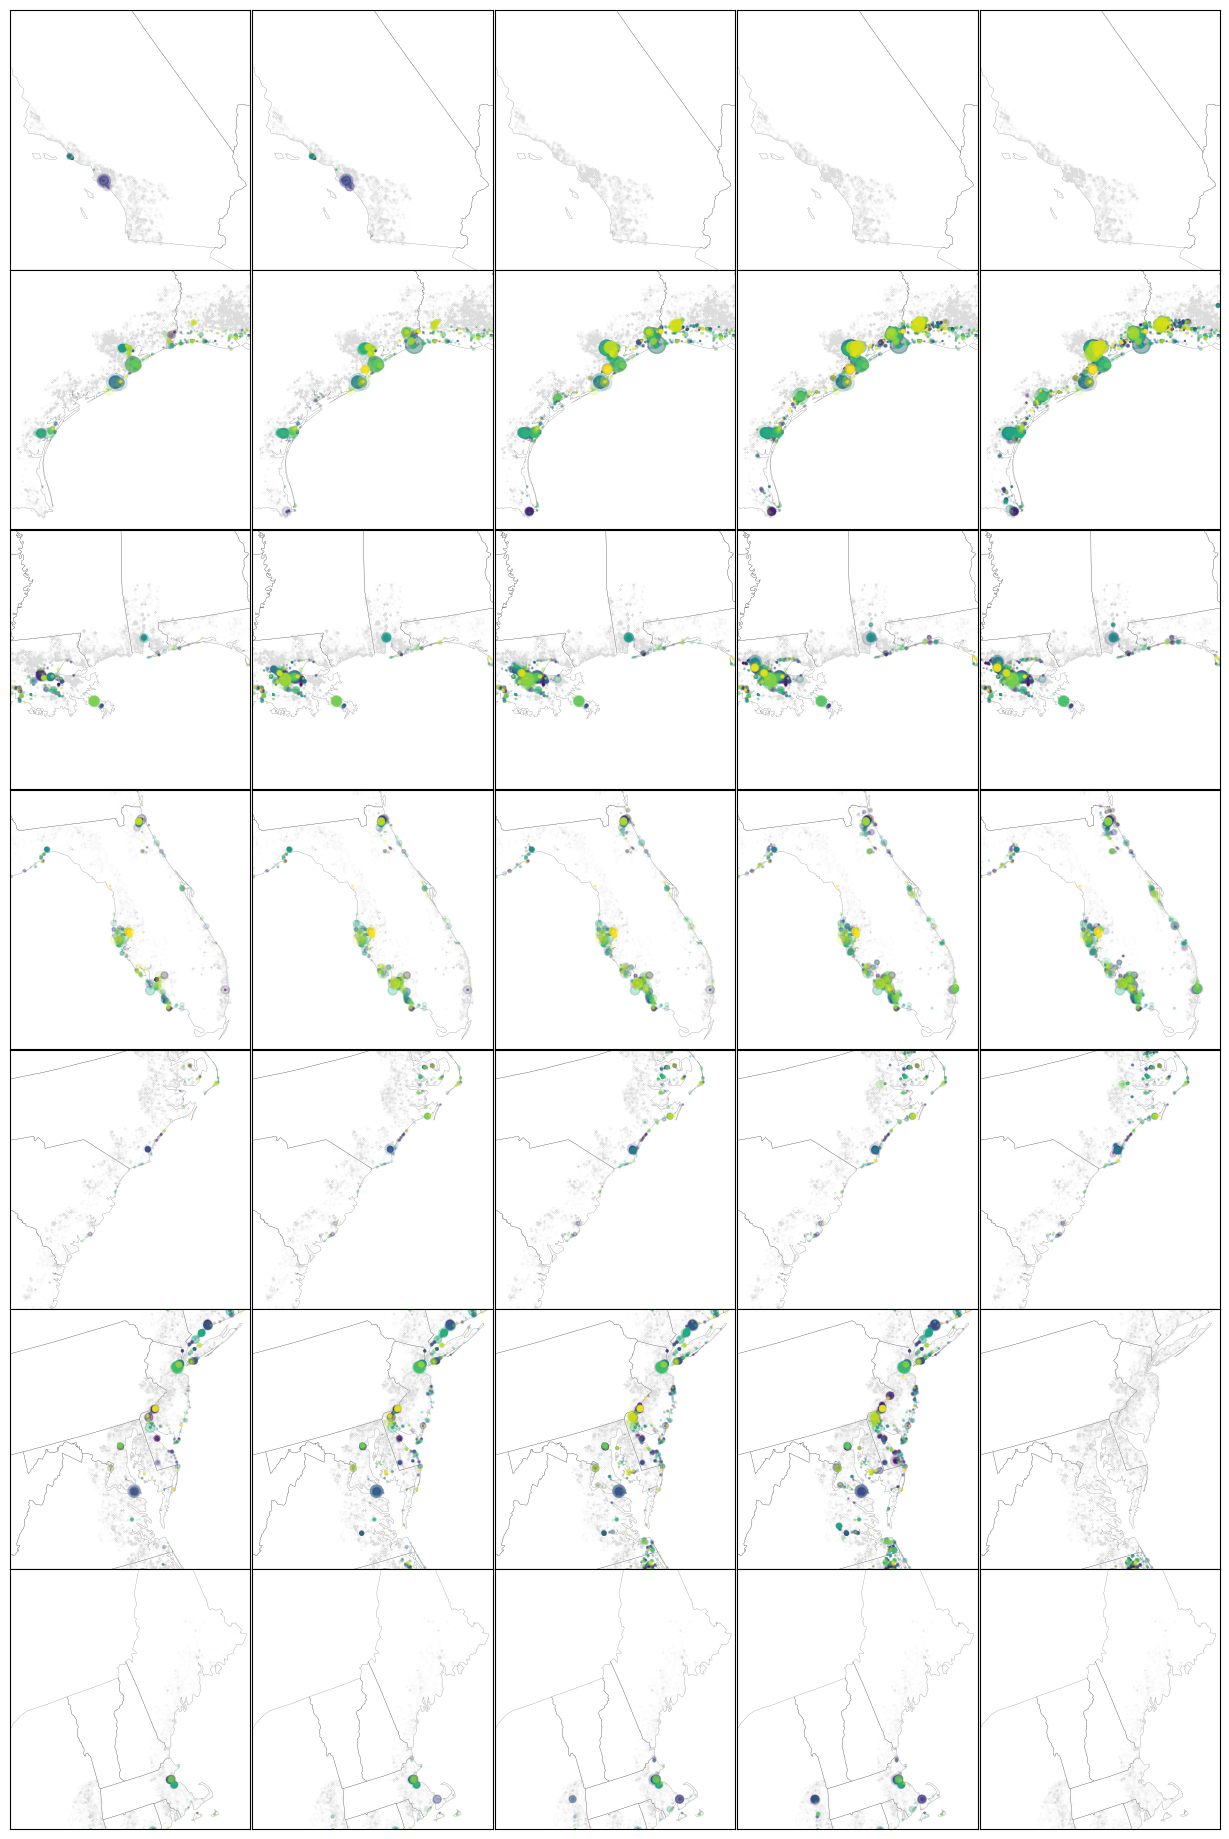

In [20]:
fig, axes = plt.subplots(nrows = 7, ncols = 5, figsize=(15.635, 23.625))

for j, ax in enumerate(range(5)): #iterate over categories
    tank_gdf = tank_gdfs[j]
    tank_gdf = tank_gdf.to_crs("EPSG:2163")
    
    for i, extent in enumerate(extents):
        ax = axes[i,j]
        # Plot inset data
        state_boundary.plot(ax=ax, facecolor="none", 
                        edgecolor='black', lw=0.2, zorder=0, alpha = 0.5)
        compiled_predicted_tank["centroid"].plot(markersize=0.01, color="gainsboro", ax=ax,
                                                 zorder=1, alpha = 0.1)
        tank_gdf["centroid"].plot(markersize=tank_gdf['capacity']/1_000, 
                                  c=tank_gdf['inundation'], alpha = 0.15, 
                                  zorder=2, ax=ax, cmap="viridis")

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(extent[0])
        ax.set_ylim(extent[1])
        
plt.subplots_adjust(wspace=0.001, hspace=0.001)

(-1300000.0, -625000.0)

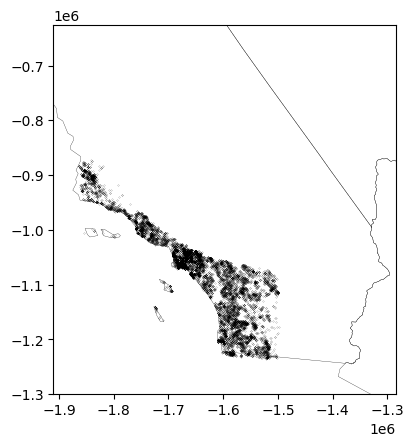

In [138]:




fig, ax = plt.subplots()

state_boundary.plot(ax=ax, facecolor="none", 
                        edgecolor='black', lw=0.2, zorder=0)
compiled_predicted_tank["centroid"].plot(markersize=0.01, color="black", ax=ax)

tank_gdf["centroid"].plot(markersize=tank_gdf['capacity']/1_000, 
                          c=tank_gdf['inundation'], alpha = 0.15, 
                          zorder=2, ax=ax, cmap="Blues")
ax.set_xlim(california_extent[0])
ax.set_ylim(california_extent[1])

In [108]:
    
fig, axes = plt.subplot(nrows=4, ncols=5)

for region in regions
    tank_gdf["centroid"].plot(alpha = 0.05, zorder=1, markersize=,
                              c=ax = ax)

# Plot inset data
tank_gdf["centroid"].plot(markersize=tank_gdf['height'], 
                          c=tank_gdf['inundation'],
                          alpha = 0.1, zorder=2, ax=inset_ax,
                          cmap="Blues")

    ax.set_title('', pad=10)
    ax.set_xlim([-100, -67])
    ax.set_ylim([23, 48])
    ax.set_axis_off()

# Add inset axis
inset_ax = fig.add_axes([0.15, 0.55, 0.3, 0.3])
state_boundary.plot(ax=inset_ax, facecolor="none", 
                    edgecolor='black', lw=0.2, zorder= 0)
# Plot inset data
compiled_predicted_tank["centroid"].plot(alpha = 0.05, zorder=1, 
                                         markersize=0.01,
                                         ax = inset_ax)
inset_ax.set_xlim([-120,-115])
inset_ax.set_ylim([31, 35])


plt.show()

SyntaxError: expected ':' (534317719.py, line 3)

In [35]:
detected_tanks_slosh_data_added_gdf.drop_duplicates(subset="id")

,id,height,diameter,object_class,confidence,geometry,inundation,leveed_areas,category,capacity
172,172,14.92800,55.2,closed_roof_tank,0.9334467649459839,"POLYGON ((-72.89391 41.33423, -72.89391 41.333...",3.064103,False,Category1,35724.788409
173,173,15.55400,39.0,closed_roof_tank,0.929155170917511,"POLYGON ((-72.89404 41.33359, -72.89404 41.333...",1.891304,False,Category1,18580.662802
174,174,15.00000,39.0,closed_roof_tank,0.9288744926452637,"POLYGON ((-72.89293 41.33415, -72.89293 41.333...",4.166667,False,Category1,17918.859098
175,175,15.74000,39.0,closed_roof_tank,0.891961544752121,"POLYGON ((-72.89343 41.33331, -72.89343 41.332...",2.428571,False,Category1,18802.855873
176,176,15.76955,39.0,closed_roof_tank,0.9315288066864014,"POLYGON ((-72.89405 41.33309, -72.89405 41.332...",1.625000,False,Category1,18838.156344
...,...,...,...,...,...,...,...,...,...,...
192343,192343,NaN,6.6,closed_roof_tank,0.7223954796791077,"POLYGON ((-76.51406 36.33181, -76.51406 36.331...",5.500000,False,Category5,NaN
192344,192344,NaN,6.6,closed_roof_tank,0.637923002243042,"POLYGON ((-76.51404 36.33175, -76.51404 36.331...",5.500000,False,Category5,NaN
192375,192375,NaN,8.4,closed_roof_tank,0.739919126033783,"POLYGON ((-76.54560 36.32614, -76.54560 36.326...",0.500000,False,Category5,NaN
192635,192635,NaN,6.0,closed_roof_tank,0.6181855797767639,"POLYGON ((-76.37281 35.46511, -76.37281 35.465...",11.500000,False,Category5,NaN


# Summary Statistics on capacity

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_79457/474232661.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [30]


IndexError: list index out of range

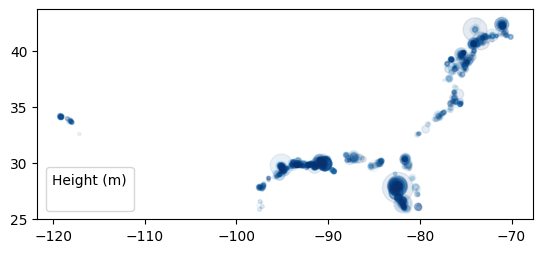

In [18]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
tank_gdf["centroid"].plot(markersize=tank_gdf['height'], 
                          c=tank_gdf['inundation'],
                          alpha = 0.1, zorder=2, ax =ax,
                         cmap="Blues")


# Create legend
legend1 = ax.legend(scatterpoints=1, frameon=True, 
                    labelspacing=1, loc='lower left', 
                    fontsize=12,
                    title='Height (m)')

# Add marker size indicator 
from matplotlib.lines import Line2D
legend1.legendHandles[0]._sizes = [30]
legend1.legendHandles.insert(0, Line2D([0], [0], marker='o',  
                           markersize=15,
                           label='5 m',
                           color='w'))

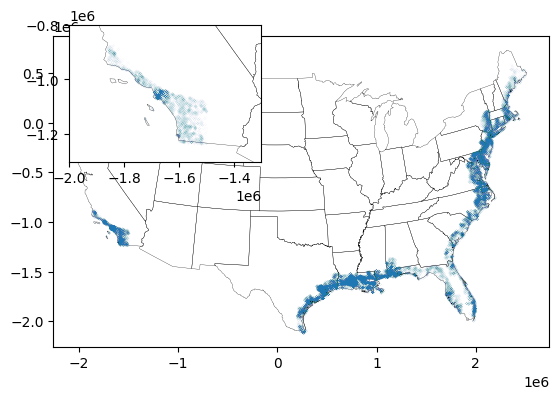

In [78]:
fig, ax = plt.subplots()
state_boundary.plot(ax=ax, facecolor="none", 
                    edgecolor='black', lw=0.2, zorder= 0)
compiled_predicted_tank["centroid"].plot(alpha = 0.05, zorder=1, markersize=0.01,
                                         ax = ax)


ax.set_title('', pad=10)
#ax.set_xlim([-100, -67])
#ax.set_ylim([23, 48])
#ax.set_axis_off()

# Add inset axis
inset_ax = fig.add_axes([0.15, 0.55, 0.3, 0.3])
state_boundary.plot(ax=inset_ax, facecolor="none", 
                    edgecolor='black', lw=0.2, zorder= 0)
 #Plot inset data
compiled_predicted_tank["centroid"].plot(alpha = 0.05, zorder=1, 
                                         markersize=0.01,
                                         ax = inset_ax)
inset_ax.set_xlim([-2e6, -1.3e6])
inset_ax.set_ylim([-1.3e6, -0.8e6])

plt.show()

In [ ]:
-1e6

In [96]:
annotated_tanks_in_slosh = gpd.clip(compiled_predicted_tank, state_boundary[state_boundary.STATE_NAME == "California"])

In [ ]:

# Create legend
for area in [1, 10, 50]:
    ax.scatter([0], [0], c='black' , alpha=0.9, s=area,
                label=str(area) + ' m3')
# Creates the legend with black circles
legend1 = ax.legend(scatterpoints=1, #frameon=True,
        labelspacing=1, loc='lower right', fontsize=8, 
        #bbox_to_anchor=(0.03,0.05),
        title="capacity", 
        title_fontsize=8)

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
state_boundary.plot(ax=ax, facecolor="none", 
                    edgecolor='black', lw=0.2, zorder=0)
cat1_slosh_boundary.plot(ax=ax, facecolor="gainsboro", 
                         edgecolor='gainsboro', lw=0.5, alpha=.01, zorder=1)
detected_tanks["centroid"].plot(markersize=detected_tanks['capacity']/1_000_000, ax=ax, alpha = 0.5, zorder=2)
ax.set_xlim([-100,-67])
ax.set_ylim([23, 46])

In [ ]:
    #subset tanks by those that have inundation data (by category)
    # identify column name corresponding to inundation data
    slosh_cols_by_category = list_of_list_of_inundation_categories(args.temp_key)
    #specify column names needed for analysis 
    inundation_values_for_analysis_dict = subset_tanks_with_data_by_category(tile_level_annotations_subset_tank_classes_slosh_gdf,
                                                                             general_variables, slosh_cols_by_category)
    #write to file
    inundation_values_for_analysis_gdf = combine_inundation_data_for_analysis(inundation_values_for_analysis_dict)
    inundation_values_for_analysis_gdf.to_file(os.path.join(args.output_dir, 
                                                            args.tile_level_annotations_fragility_analysis_output_filename +".geojson"), 
                                                            driver='GeoJSON')
    
    inundation_values_for_analysis_gdf_unique_tanks = inundation_values_for_analysis_gdf.drop_duplicates(subset=['id']).drop(["object_class",
                                                                            "diameter","inundation","leveed_areas","category"],axis=1)
    
    inundation_values_for_analysis_gdf_unique_tanks.to_file(os.path.join(args.output_dir,
                                                    args.tile_level_annotations_fragility_analysis_output_filename+"_unique_tanks.geojson"),
                                                            driver='GeoJSON')

In [7]:
#subset based on available data
detected_tanks_gdf = detected_tanks_gdf[detected_tanks_gdf['height'].notnull()]
detected_tanks_gdf_with_capacity = detected_tanks_gdf[~detected_tanks_gdf["capacity"].isnull()] 
detected_tanks_gdf_with_capacity = detected_tanks_gdf_with_capacity[detected_tanks_gdf_with_capacity["diameter"]>0]

detected_tanks_gdf_with_capacity_height_subset = detected_tanks_gdf_with_capacity[(detected_tanks_gdf_with_capacity["height"]<30) & \
                                                (detected_tanks_gdf_with_capacity["height"]>2)]

detected_tanks_gdf_with_capacity_height_subset.to_parquet("/hpc/group/borsuklab/csr33/object_detection/detected_tanks_gdf_with_capacity_height_subset.parquet")
detected_tanks_gdf_with_capacity_height_subset[["height", "diameter", "capacity", "specific_gravity","geometry"]].to_file("/hpc/group/borsuklab/csr33/object_detection/detected_tanks_gdf_with_capacity_height_subset.geojson", driver='GeoJSON')

(0.0, 100.0)

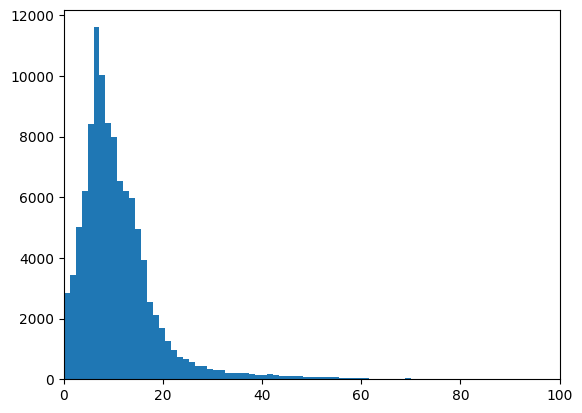

In [55]:
import matplotlib.pyplot as plt
plt.hist(detected_tanks_gdf_with_capacity["height"], bins=1000)
plt.xlim([0,100])

In [77]:
#detected_tanks_gdf_with_capacity_height_subset.sort_values("capacity", ascending=False)

In [7]:
rewrite to do capacity for complete predicted data?
where did specific gravity go?

,confidence,class_name,bbox_pixel_coords,tile_names,utm_coords,diameter,utm_proj,geometry,height,chemical_name,cas_number,facility_name
319,"[0.9214309453964233, 0.6490179896354675]",['closed_roof_tank'],"[11499, 14465, 11661, 14621]",m_3009122_ne_15_030_20211116,"[664775.85, 3399064.35, 664824.4500000001, 339...",46.8,EPSG:26915,"POLYGON ((-91.27874 30.71304, -91.27874 30.712...",16.500000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
249,"[0.9202601313591003, 0.778704822063446]",['closed_roof_tank'],"[13418, 16036, 13550, 16152]",m_3009122_ne_15_030_20211116,"[665351.55, 3398593.0500000003, 665391.15, 339...",34.8,EPSG:26915,"POLYGON ((-91.27290 30.70871, -91.27290 30.708...",15.720000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
250,"[0.914099931716919, 0.9086913466453552]",['closed_roof_tank'],"[13439, 16534, 13620, 16743]",m_3009122_ne_15_030_20211116,"[665357.85, 3398443.65, 665412.15, 3398380.95]",54.3,EPSG:26915,"POLYGON ((-91.27271 30.70736, -91.27271 30.706...",14.760000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
251,"[0.9115021228790283, 0.8991819620132446]",['closed_roof_tank'],"[13347, 16234, 13572, 16442]",m_3009122_ne_15_030_20211116,"[665330.25, 3398533.65, 665397.75, 3398471.25]",62.4,EPSG:26915,"POLYGON ((-91.27285 30.70817, -91.27285 30.707...",14.760000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
273,"[0.910485029220581, 0.8887038230895996]",['closed_roof_tank'],"[12302, 13366, 12429, 13482]",m_3009122_ne_15_030_20211116,"[665016.75, 3399394.0500000003, 665054.85, 339...",34.8,EPSG:26915,"POLYGON ((-91.27628 30.71598, -91.27628 30.715...",15.690000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
...,...,...,...,...,...,...,...,...,...,...,...,...
637,0.5014625191688538,closed_roof_tank,"[8686, 22518, 8693, 22525]",m_3109062_sw_15_030_20211120,"[752780.8500000001, 3433233.75, 752782.9500000...",2.1,EPSG:26915,"POLYGON ((-90.35241 31.00561, -90.35241 31.005...",NaN,None,None,None
993,0.5012210607528687,closed_roof_tank,"[8186, 485, 8194, 493]",m_3308062_nw_17_060_20210426,"[563013.9, 3665264.7, 563018.7000000001, 36652...",4.8,EPSG:26917,"POLYGON ((-80.32445 33.12425, -80.32445 33.124...",NaN,None,None,None
854,0.501176118850708,closed_roof_tank,"[271, 24061, 283, 24071]",m_3009034_ne_15_030_20211120,"[709821.4500000001, 3369329.5500000003, 709825...",3.0,EPSG:26915,"POLYGON ((-90.81507 30.43783, -90.81507 30.437...",18.610001,None,None,None
390,0.5011230707168579,closed_roof_tank,"[4551, 5386, 4559, 5394]",m_2608040_sw_17_060_20191120_20200113,"[589770.9, 2921444.1, 589775.7000000001, 29214...",4.8,EPSG:26917,"POLYGON ((-80.09981 26.41036, -80.09981 26.410...",NaN,['Zinc compounds'],['N982'],[NHS U.S. LLC]


In [4]:
slosh_boundary_dir = "/datacommons/borsuklab-ast-archive/nat_hazard_data/slosh/unzip/v3_extent_shp"
cat1_slosh_boundary = gpd.read_file(os.path.join(slosh_boundary_dir, "cat1_merge_Dissolve.shp")).to_crs(crs)

original_ast_dataset = gpd.read_file("/datacommons/borsuklab-ast-archive/ast/tile_level_annotation_multiple_capture_date_neighbor_tile_removed/tile_level_annotation_multiple_capture_date_neighbor_tile_removed.geojson")

In [6]:
original_ast_dataset.sjoin(cat1_slosh_boundary)

,id,object_class,tile_name,image_name,nw_x_pixel_object_coord,nw_y_pixel_object_coord,se_x_pixel_object_coord,se_y_pixel_object_coord,utm_projection,nw_x_utm_object_coord,...,merged_bbox,county,state_fips,county_fips,quad_id,capture_date,geometry,index_right,Shape_Leng,Shape_Area
0,0,closed_roof_tank,m_4007327_nw_18_060_20190809,"[m_4007327_nw_18_060_20190809_00_01, m_4007327...",973,313,1040,379,EPSG:26918,606104.1,...,True,Nassau,36,36059,4007327_nw,20190809,"POLYGON ((-73.74547 40.62539, -73.74547 40.625...",0,278.16452,115.70821
1,1,closed_roof_tank,m_4007327_nw_18_060_20190809,[m_4007327_nw_18_060_20190809_00_02],1090,478,1156,511,EPSG:26918,606174.3,...,False,Nassau,36,36059,4007327_nw,20190809,"POLYGON ((-73.74465 40.62467, -73.74465 40.624...",0,278.16452,115.70821
2,2,closed_roof_tank,m_4007327_nw_18_060_20190809,[m_4007327_nw_18_060_20190809_00_01],850,242,871,264,EPSG:26918,606030.3,...,False,Nassau,36,36059,4007327_nw,20190809,"POLYGON ((-73.74633 40.62603, -73.74633 40.626...",0,278.16452,115.70821
3,3,closed_roof_tank,m_4007327_nw_18_060_20190809,[m_4007327_nw_18_060_20190809_00_01],842,283,896,334,EPSG:26918,606025.5,...,False,Nassau,36,36059,4007327_nw,20190809,"POLYGON ((-73.74639 40.62565, -73.74639 40.625...",0,278.16452,115.70821
4,4,closed_roof_tank,m_4007327_nw_18_060_20190809,[m_4007327_nw_18_060_20190809_00_01],904,287,944,330,EPSG:26918,606062.1,...,False,Nassau,36,36059,4007327_nw,20190809,"POLYGON ((-73.74595 40.62566, -73.74595 40.625...",0,278.16452,115.70821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117423,133026,narrow_closed_roof_tank,m_3009148_sw_15_060_20190906,[m_3009148_sw_15_060_20190906_24_12],6584,12436,6591,12445,EPSG:26915,683936.1,...,False,Iberville,22,22047,3009148_sw,20190906,"POLYGON ((-91.08828 30.24876, -91.08828 30.248...",0,278.16452,115.70821
117424,133027,narrow_closed_roof_tank,m_3009148_sw_15_060_20190906,[m_3009148_sw_15_060_20190906_24_12],6576,12458,6583,12466,EPSG:26915,683931.3,...,False,Iberville,22,22047,3009148_sw,20190906,"POLYGON ((-91.08833 30.24865, -91.08833 30.248...",0,278.16452,115.70821
117425,133028,narrow_closed_roof_tank,m_3009148_sw_15_060_20190906,[m_3009148_sw_15_060_20190906_24_12],6466,12363,6476,12375,EPSG:26915,683865.3,...,False,Iberville,22,22047,3009148_sw,20190906,"POLYGON ((-91.08901 30.24917, -91.08901 30.249...",0,278.16452,115.70821
117426,133029,closed_roof_tank,m_3009148_sw_15_060_20190906,[m_3009148_sw_15_060_20190906_17_01],906,8719,935,8746,EPSG:26915,680529.3,...,False,Iberville,22,22047,3009148_sw,20190906,"POLYGON ((-91.12329 30.26939, -91.12329 30.269...",0,278.16452,115.70821


In [7]:
annotated_tanks_in_slosh = gpd.clip(original_ast_dataset, cat1_slosh_boundary)

In [11]:
annotated_tanks_in_slosh_subset_by_detected_class = annotated_tanks_in_slosh[annotated_tanks_in_slosh.object_class.isin(["narrow_closed_roof_tank", "closed_roof_tank", 
                                                                                                                        "external_floating_roof_tank", "spherical_tank"])]

In [15]:
num_annotated_tanks_in_slosh = len(annotated_tanks_in_slosh_subset_by_detected_class)

In [24]:
num_closed_roof_tanks = len(annotated_tanks_in_slosh_subset_by_detected_class[annotated_tanks_in_slosh_subset_by_detected_class.object_class.isin(["spherical_tank"])])
print(num_closed_roof_tanks)
num_closed_roof_tanks/num_annotated_tanks_in_slosh

665


0.0211399688463617

In [ ]:
compiled_predicted_tank = gpd.read_file("/hpc/group/borsuklab/csr33/object_detection/compiled_predicted_tank.geojson")
print(compiled_predicted_tank.object_class.value_counts())
print(sum(compiled_predicted_tank.object_class.value_counts()))

In [ ]:
annotated_tanks_in_slosh

In [23]:
detected_tanks = gpd.read_file("/hpc/group/borsuklab/csr33/object_detection/detected_tanks_slosh_data_added.geojson")
#detected_tanks_in_slosh = gpd.clip(detected_tanks, cat1_slosh_boundary)



KeyboardInterrupt



In [ ]:
annotated_tanks_in_slosh